# CNN Model Training

## Import Common Libraries

In [1]:
import numpy as np

## Define paths

In [2]:
cnn_features_dir = "../data/features/audio_16k/augmented_mfcc+deltas_prosodic/audio_features"
metadata_dir = "../data/features/audio_16k/augmented_mfcc+deltas_prosodic/metadata.csv"

## Load Metadata

In [3]:
import pandas as pd

df = pd.read_csv(metadata_dir)
print(f"Total samples: {len(df)}")

Total samples: 45272


## Encode labels for CNN

In [4]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

# Prepare labels
le = LabelEncoder()
y_int = le.fit_transform(df['emotion'])      # convert emotions to integers
y_onehot = to_categorical(y_int) # one-hot encoding for softmax

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_int), y=y_int)
class_weight_dict = dict(enumerate(class_weights))

num_classes = len(le.classes_)

print("Number of classes:", num_classes)

2025-11-25 20:51:30.988450: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 20:51:31.023121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 20:51:31.753097: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Number of classes: 6


## Train/test split

In [5]:
from sklearn.model_selection import train_test_split

file_paths = df['file_path'].values

train_paths, test_paths, y_train, y_test = train_test_split(
    file_paths, y_onehot, test_size=0.2, stratify=y_int, random_state=42
)

print(f"Training samples: {len(train_paths)}")
print(f"Test samples: {len(test_paths)}")

Training samples: 36217
Test samples: 9055


## Create Generators

In [6]:
import sys
sys.path.append("../src")
import classes
from classes import AudioDataGenerator

train_gen = AudioDataGenerator(train_paths, y_train, batch_size=32, shuffle=True)
test_gen = AudioDataGenerator(test_paths, y_test, batch_size=32, shuffle=False)

print(f"Training batches per epoch: {len(train_gen)}")
print(f"Test batches: {len(test_gen)}")

Training batches per epoch: 1132
Test batches: 283


## Define CNN Architecture

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, GlobalAveragePooling2D, Input

input_shape = (120, 150, 1)

model = Sequential([
    Input(input_shape),

    # BLOCK 1: Early features
    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # BLOCK 2: Mid-level features
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    # BLOCK 3: High-level features
    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    # TRANSITION: 2D → 1D
    GlobalAveragePooling2D(),
    
    # CLASSIFICATION
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

I0000 00:00:1764075095.294789     761 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


## Compile the model

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

## Train the Model

In [9]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=100,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100


2025-11-25 20:51:39.278060: I external/local_xla/xla/service/service.cc:163] XLA service 0x791bd801c780 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-25 20:51:39.278100: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-11-25 20:51:39.340484: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-25 20:51:39.823662: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-11-25 20:51:40.151724: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:51:40.

 869/1132 ━━━━━━━━━━━━━━━━━━━━ 22s 84ms/step - accuracy: 0.2291 - loss: 2.0382

2025-11-25 20:53:12.330931: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:53:12.330989: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:53:12.331019: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:53:12.331028: I external/l

1132/1132 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2409 - loss: 1.9781

2025-11-25 20:53:47.062436: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_268', 20 bytes spill stores, 20 bytes spill loads

2025-11-25 20:53:56.655940: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:53:56.655993: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 20:53:57.218052: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

1132/1132 ━━━━━━━━━━━━━━━━━━━━ 144s 108ms/step - accuracy: 0.2905 - loss: 1.7450 - val_accuracy: 0.1742 - val_loss: 5.6459 - learning_rate: 5.0000e-04
Epoch 2/100
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 102s 90ms/step - accuracy: 0.4431 - loss: 1.3645 - val_accuracy: 0.2425 - val_loss: 2.6032 - learning_rate: 5.0000e-04
Epoch 3/100
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 102s 90ms/step - accuracy: 0.5262 - loss: 1.2059 - val_accuracy: 0.4876 - val_loss: 1.3072 - learning_rate: 5.0000e-04
Epoch 4/100
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 102s 90ms/step - accuracy: 0.5788 - loss: 1.0920 - val_accuracy: 0.4190 - val_loss: 1.8251 - learning_rate: 5.0000e-04
Epoch 5/100
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 101s 89ms/step - accuracy: 0.6135 - loss: 1.0134 - val_accuracy: 0.5284 - val_loss: 1.6825 - learning_rate: 5.0000e-04
Epoch 6/100
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 102s 90ms/step - accuracy: 0.6399 - loss: 0.9511 - val_accuracy: 0.6466 - val_loss: 0.9028 - learning_rate: 5.0000e-04
Epoch 7/100
1132/1132 ━━━━━━━━━━━━━━━━━

## Make Predictions

In [10]:
# Predict probabilities
y_pred_prob = model.predict(test_gen)

# Convert to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels as class indices
y_true = np.argmax(y_test, axis=1)

283/283 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step


## Evaluate Model

### Accuracy, Precision, Recall, F1-score

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-score: {f1:.4f}")

Accuracy: 0.9272
Weighted Precision: 0.9277
Weighted Recall: 0.9272
Weighted F1-score: 0.9270


### Confusion Matrix

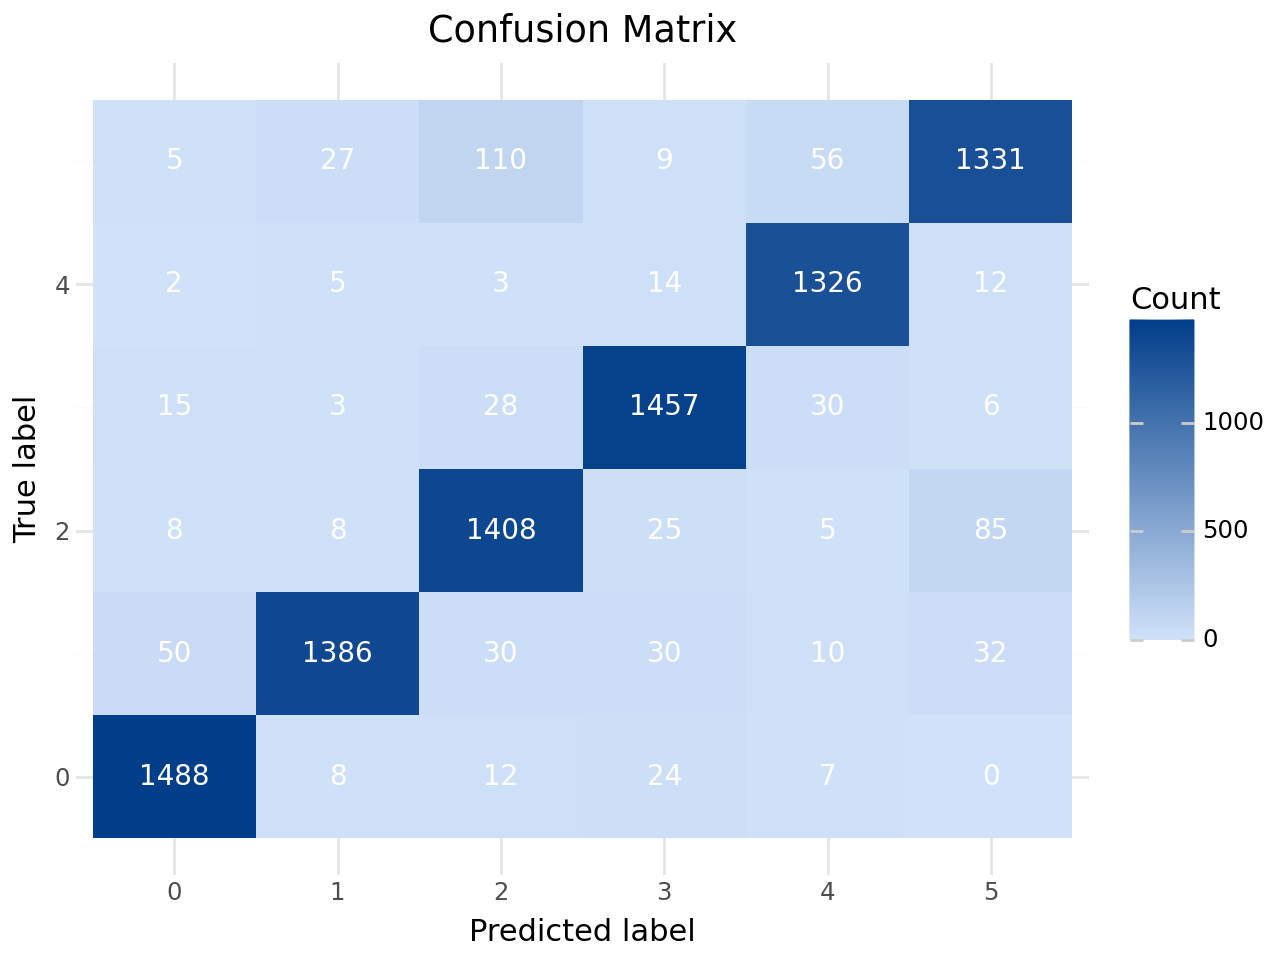

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from plotnine import *

# Convert probabilities → predicted classes
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot labels → true classes
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
labels = sorted(np.unique(np.concatenate([y_true, y_pred])))
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Convert to tidy DataFrame for plotnine
df_cm = (
    pd.DataFrame(cm, index=labels, columns=labels)
      .reset_index()
      .melt(id_vars='index')
)

df_cm.columns = ['True', 'Predicted', 'Count']

# Plot confusion matrix
(
    ggplot(df_cm, aes('Predicted', 'True', fill='Count'))
    + geom_tile()
    + geom_text(aes(label='Count'), color='white', size=10)
    + scale_fill_gradient(low='#d0e1f9', high='#023e8a')
    + theme_minimal()
    + labs(title='Confusion Matrix', x='Predicted label', y='True label')
)

### Unweighted Average Recall (UAR)

In [13]:
uar = recall_score(y_true, y_pred, average='macro')
print(f"Unweighted Average Recall (UAR): {uar:.4f}")

Unweighted Average Recall (UAR): 0.9281


### Detailed classification report

In [14]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=le.classes_)
print(report)

              precision    recall  f1-score   support

       angry       0.95      0.97      0.96      1539
     disgust       0.96      0.90      0.93      1538
        fear       0.88      0.91      0.90      1539
       happy       0.93      0.95      0.94      1539
     neutral       0.92      0.97      0.95      1362
         sad       0.91      0.87      0.89      1538

    accuracy                           0.93      9055
   macro avg       0.93      0.93      0.93      9055
weighted avg       0.93      0.93      0.93      9055

